In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import sys
from astropy.cosmology import Planck15
import os

import matplotlib.lines as mlines
from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

# Gunn-Peterson optical depth

$$ \tau_{GP} = \int_0^{z^s} dz c\frac{dt}{dz} n_{HI}(z) \sigma_\alpha(z) $$

Optical depth $\sigma_\alpha(z) = \sigma_0 \sqrt{\pi} \phi\left(\nu\frac{1+z}{1+z_s} - \nu_\alpha\right) $

where $\nu$ is emitted frequency. $\sigma_0 = \frac{f \sqrt{\pi} e^2}{m_e c \Delta \nu_D}$.

As cross-section is tightly peaked:

\begin{align}
\sigma_\alpha(z) &= \sigma_0 \sqrt{\pi} \phi\left(\frac{\nu\frac{1+z}{1+z_s} - \nu_\alpha}{\Delta \nu_D}\right) \\
                 &= \sigma_0 \sqrt{\pi} \delta\left(\frac{\nu\frac{1+z}{1+z_s} - \nu_\alpha}{\Delta \nu_D}\right) \\
                 &\approx \sigma_0 \sqrt{\pi} \frac{(1+z_s)\Delta \nu_D}{\nu} \delta(z - z_s) 
\end{align}

Thus the optical depth:

\begin{align}
\tau_{GP} &= c\frac{dt}{dz}(z_s) n_{HI}(z_s) \sigma_0 \sqrt{\pi} \Delta \nu_D \frac{1+z_s}{\nu}  \\
          &= \frac{c}{H(z_s)(1+z_s)} n_{HI}(z_s) \sigma_0 \sqrt{\pi}\Delta \nu_D \frac{1+z_s}{\nu} \\
          &= \frac{n_{HI}(z_s)}{H(z_s)} \frac{c \sigma_0 \sqrt{\pi}\Delta \nu_D}{\nu} \\ 
          &= \boxed{\frac{n_{HI}(z_s)}{H(z_s)} \sigma_0 \sqrt{\pi}  v_\mathrm{th} = \boxed{\frac{n_{HI}(z_s)}{H(z_s)} \mathcal{A}}}
\end{align}



## Cross-section

$$ \sigma_0 = f \frac{\sqrt{\pi} e^2}{m_e c \Delta \nu_D} $$

$$ \sigma_0 = 5.9\times10^{-14} \left(\frac{T}{10^4 \mathrm{K}}\right)^{-1/2} \mathrm{cm}^2 $$

$$ \Delta \nu_D = \nu_\alpha \sqrt{\frac{2kT}{m_p c^2}} = \nu_\alpha v_\mathrm{th}/c$$

In [21]:
# Cross-section
lya_cross = bubbles.lya_cross_section(T=1e4*u.K)

A = np.sqrt(np.pi) * lya_cross.sig_Lya0 * u.cm**2 * lya_cross.v_therm
print(A.to('cm**3/s'))


## What is A?
falpha = 0.416
lambda_alpha = 1215.67 * u.Angstrom
A = falpha * np.pi * const.e.gauss**2 * lambda_alpha / (const.m_e * const.c)
print(A.to('cm**3/s'))

nu_alpha = (const.c/lambda_alpha).to(u.Hz)
print("{0:0.3e}".format(nu_alpha))
A = falpha * np.pi * const.e.gauss**2 / (const.m_e * nu_alpha)
print(A.to('cm**3/s'))

1.3436454774474527e-07 cm3 / s
1.3421819608040695e-07 cm3 / s
2.466e+15 Hz
1.3421819608040692e-07 cm3 / s


## Compare to doing integral

In [96]:
def optical_depth(T, z_min, z_s, xHI=1, tanh_xHI=False,
                  wave_em=1216.*u.Angstrom, C_HII=3., xtab_len=100):
    """
    Gunn-Peterson optical depth integral
    """
    crosssec = bubbles.lya_cross_section(T)   
    
    # Redshift array
    ztab_ends = np.array([z_min, z_s])
    
    # Observed wavelength
    wave_obs = wave_em * (1. + z_s)
        
    # Range of redshifted wavelength and x    
    wave_z_ends = wave_obs/(1+ztab_ends)
    x_z_ends    = crosssec.Lya_wave_to_x(wave_z_ends).value

    # Make xtab       
    xtab_neg = -np.logspace(-1,np.log10(-x_z_ends.min()),int(xtab_len/2))
    xtab_pos = np.logspace(-1,np.log10(x_z_ends.max()),int(xtab_len/2))
    xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

    # Get wave_redshift
    wave_redshift = crosssec.Lya_x_to_wave(xtab)

    # Get z tab
    ztab = (wave_obs/wave_redshift - 1.).value
    
    if tanh_xHI is False:
        xHI = xHI
    else:
        xHI = xHI_tanh(z=ztab, z_reion=7., delta_z=0.5)

    # Cross-section
    lya_cross = crosssec.Lya_crosssec_x(xtab)

    # Calculate optical depth
    prefac = (const.c * bubbles.dt_dz(ztab) * xHI * bubbles.n_H(ztab)).to(1./u.cm**2.)
    dtau   = prefac * lya_cross

    tau = np.trapz(dtau, ztab)
        
    return tau

print(optical_depth(T=1e4*u.K, z_min=6, z_s=7, wave_em=1215.*u.Angstrom))
print(optical_depth(T=1*u.K, z_min=6, z_s=7, wave_em=1215.*u.Angstrom))

467910.7065944513
485792.5700677257


### Semi-numerical GP tau

In [75]:
def tau_GP(z, xHI=1, C=1):
    A = 1.34e-7*u.cm**3./u.s
    tau = A*C*xHI * bubbles.n_H(z)/Planck15.H(z)
    return tau.to(u.cm/u.cm)

tau_0 = tau_GP(0.) * (1+7)**1.5 / np.sqrt(Planck15.Om0)
print('%e' % tau_0)

4.678292e+05


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
../bubbles/lya_cross_section.py:88: RuntimeWarning: invalid value encountered in greater
  
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
../bubbles/lya_cross_section.py:88: RuntimeWarning: invalid value encountered in greater
  
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
../bubbles/lya_cross_section.py:88: RuntimeWarning: invalid value encountered in greater
  
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
../bubbles/lya_cross_section.py:88: RuntimeWarning: invalid value encountered in greater
  


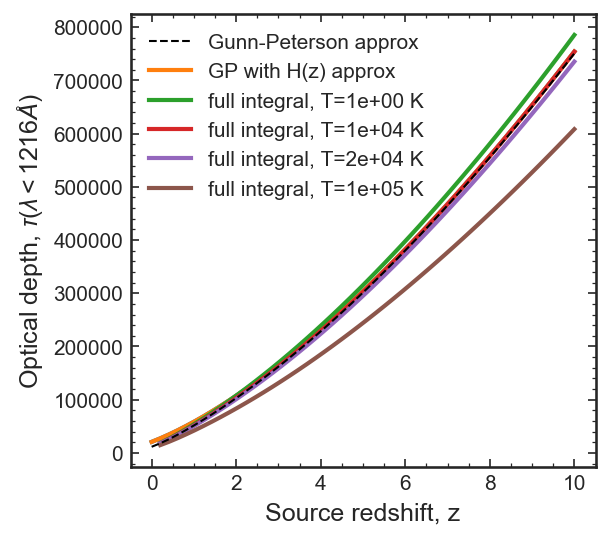

In [117]:
ztab = np.linspace(0, 10)

plt.plot(ztab, tau_GP(ztab), zorder=100, c='k', lw=1, ls='dashed', label='Gunn-Peterson approx')

plt.plot(ztab, tau_GP(0.) * (1+ztab)**3. * (1+ztab)**-1.5 / np.sqrt(Planck15.Om0))
plt.plot(ztab, tau_0*((1+ztab)/8)**1.5, label='GP with H(z) approx')

# Do integral
for T in [1, 1e4, 2e4, 1e5]:
    tau_int = [optical_depth(T=T*u.K, z_min=0, z_s=z, wave_em=1215.9*u.Angstrom) for z in ztab]
    plt.plot(ztab, tau_int, label='full integral, T=%.0e K' % (T))

plt.xlabel('Source redshift, z')
plt.ylabel(r'Optical depth, $\tau(\lambda < 1216\AA)$')
plt.legend()

### Non-constant xHI

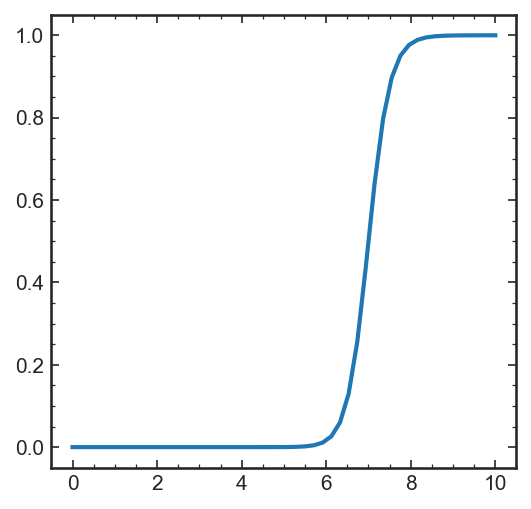

In [94]:
def xHI_tanh(z, z_reion, delta_z):
    def y(z):
        return (1+z)**1.5
    
    delta_y = 1.5*np.sqrt(1+z)*delta_z
    x_HII = 0.5 * (1 + np.tanh((y(z_reion) - y(z))/delta_y))
    return 1 - x_HII

plt.plot(ztab, xHI_tanh(z=ztab, z_reion=7., delta_z=0.5))

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
../bubbles/lya_cross_section.py:88: RuntimeWarning: invalid value encountered in greater
  
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
../bubbles/lya_cross_section.py:88: RuntimeWarning: invalid value encountered in greater
  


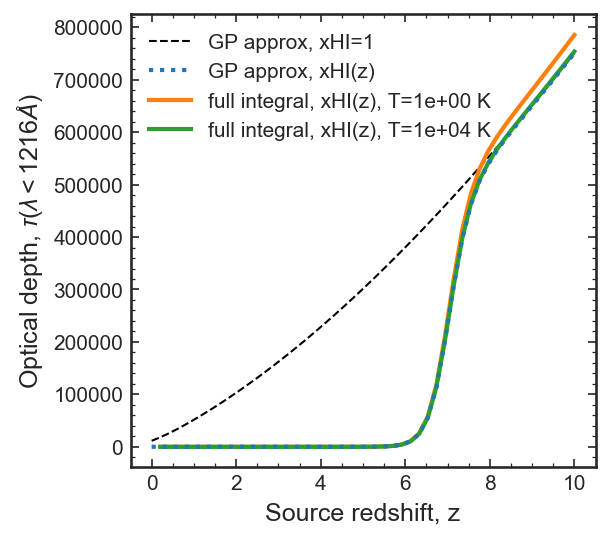

In [125]:
ztab = np.linspace(0, 10)
xHI_model = xHI_tanh(z=ztab, z_reion=7., delta_z=0.5)

plt.plot(ztab, tau_GP(ztab, xHI=1), lw=1, c='k', ls='dashed', label='GP approx, xHI=1')
plt.plot(ztab, tau_GP(ztab, xHI=xHI_model), zorder=10, ls='dotted', label='GP approx, xHI(z)')

# Do integral
for T in [1, 1e4]:
    tau_int = [optical_depth(T=T*u.K, z_min=0, z_s=z, wave_em=1215.9*u.Angstrom, tanh_xHI=True) for z in ztab]
    plt.plot(ztab, tau_int, label='full integral, xHI(z), T=%.0e K' % (T))
    
plt.xlabel('Source redshift, z')
plt.ylabel(r'Optical depth, $\tau(\lambda < 1216\AA)$')
plt.legend()

# If background dominates


In [24]:
gamma_BG_lim = (sigma0 * 1216. * u.Angstrom) * bubbles.n_H(0)**2. * bubbles.alpha_rec_B(T=1e4) / (Planck15.H0 * np.sqrt(Planck15.Om0))
gamma_BG_lim.to(1/u.s)*(8)**4.5 * 3**2./2.3

<Quantity 4.56577129e-11 1 / s>

In [21]:
(10)**4.5

31622.776601683792

# How much does xHI need to change by to drop Lya fraction by 1/2


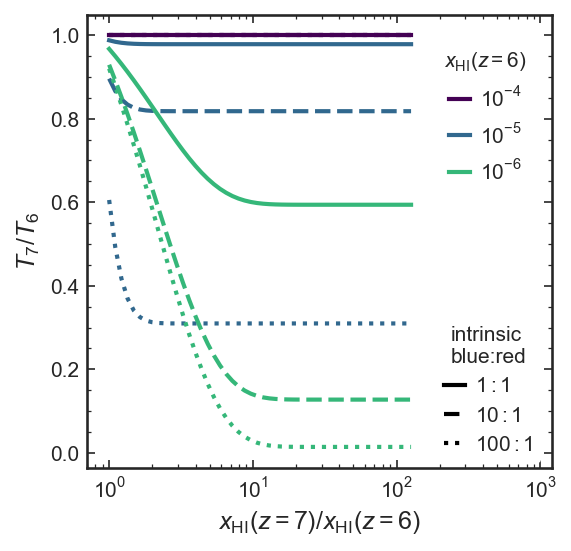

In [3]:
def tau_GP(z, xHI, C=1):
    tau = 1.34e-7*u.cm**3/u.s * C * xHI * bubbles.n_H(z)/Planck15.H(z)
    return tau.to(u.cm/u.cm)

def T_ratio(z1, z2, xHI1, dxHI, R=1, C1=1, C2=1):
    T_z1 = np.exp(-tau_GP(z1, xHI1, C=C1)) + R
    T_z2 = np.exp(-tau_GP(z2, dxHI*xHI1, C=C2)) + R
    return T_z2/T_z1
    
# xtab = np.logspace(-9, -4)
# plt.semilogx(xtab, np.exp(-(tau_GP(7, xHI=xtab) - tau_GP(6, xHI=xtab))))

xtab = np.logspace(0, 2.1)
x1   = 1e-4

R_test = [1., 0.1, 0.01]
ls = ['solid', 'dashed', 'dotted']
xHI_test = np.logspace(-4,-7,4)

s_m = bubbles.scalar_mappable(np.log10(xHI_test), cmap='viridis_r')
    
for x1 in xHI_test[:-1]:
    
    for rr, R in enumerate(R_test):
        if rr == 0:
            label = '$10^{%.0f}$' % np.log10(x1)
        else:
            label = None
        
        T_76 = T_ratio(z1=6., z2=7., xHI1=x1, dxHI=xtab, R=R, C1=1, C2=1)
        ln = plt.semilogx(xtab, T_76, c=s_m.to_rgba(np.log10(x1)), ls=ls[rr], label=label)
    
handles = []
for rr, R in enumerate(R_test):
    ln = mlines.Line2D([], [], color='k', ls=ls[rr], label=r'$%.0f:1$' % (1/R))
    handles.append(ln)
    
leg = plt.legend(loc=(0.75, 0.01), title='intrinsic\nblue:red', handles=handles, 
                 handlelength=1., handletextpad=0.5,frameon=True, framealpha=1)
plt.gca().add_artist(leg)

plt.legend(loc=(0.75, 0.61), title='$x_\mathrm{HI}(z=6)$', 
           handlelength=1., handletextpad=0.5, frameon=True, framealpha=1)
plt.xlabel('$x_\mathrm{HI}(z=7)/x_\mathrm{HI}(z=6)$')
plt.ylabel('$T_7/T_6$')

plt.xlim(7e-1, 1.2e3)

plt.savefig('../figs/transmission_blue_red.pdf', bbox_inches='tight')